In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

LAPTOP-HCR2H20M
/mnt/c/Users/mtr22/Code/MRE-PINN/notebooks


In [2]:
import sys, os
import numpy as np
import xarray as xr
import skimage
import torch
import matplotlib.pyplot as plt
nax = np.newaxis

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



False

# FEM box simulation ground truth

(295, 365, 4) 0 255
(320, 400) 0.0 1.0


<IPython.core.display.Javascript object>


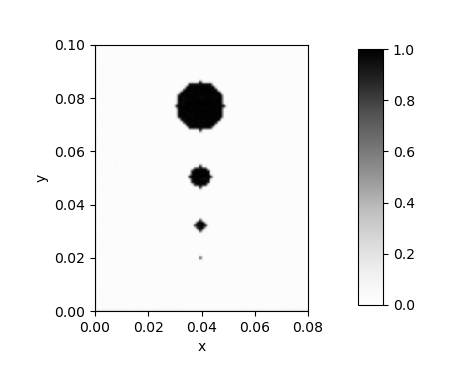

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [3]:
# read in the image file taken from the research article
im = skimage.io.imread('../data/BIOQIC/fem_box_ground_truth.png')
print(im.shape, im.min(), im.max())

# drop alpha channel and convert to inverted grayscale
im = 1 - skimage.color.rgb2gray(im[...,:-1])

# resize to data aspect ratio
im = skimage.transform.resize(im, (4*80, 4*100), anti_aliasing=True)
dx = 1e-3 / 4

# standardize to [-1, 1]
im = (im - im.min()) / (im.max() - im.min())
print(im.shape, im.min(), im.max())

# convert to xarray
im = xr.DataArray(
    im,
    dims=['x', 'y'],
    coords=dict(
        x=np.arange(320) * dx,
        y=np.arange(400) * dx
    )
)

mre_pinn.visual.XArrayViewer(im, dpi=150, cmap='Greys')

In [4]:
# convert image to scalar field
x = im.field.points()
y = im.field.values()
x.shape, y.shape

((128000, 2), (128000, 1))

100 0.00116781
200 0.00116753
300 0.00116736
400 0.00116727
500 0.00116723
600 0.00116721
700 0.00116721
800 0.00116720
900 0.00116720
1000 0.00116720
1100 0.00116720
1200 0.00116732
1300 0.00116720
1400 0.00116723
1500 0.00116721
1600 0.00116720
1700 0.00116720
1800 0.00116720
1900 0.00116720
2000 0.00116721
Parameter containing:
tensor([[0.0394, 0.0766],
        [0.0395, 0.0502],
        [0.0395, 0.0319],
        [0.0395, 0.0198]], requires_grad=True)
Parameter containing:
tensor([0.0093, 0.0042, 0.0022, 0.0005], requires_grad=True)


<IPython.core.display.Javascript object>


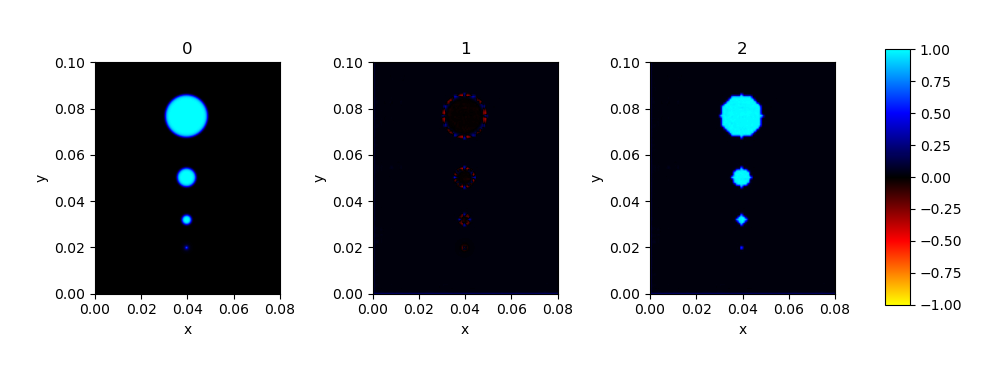

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [6]:
import torch
device = 'cpu'

# fit disk-shaped inclusions to the image

# we optimize the locations of disk-shaped kernels
# the kernels must be differentiable, not step functions

def disk(x, center, radius, power):
    dist = torch.norm(x - center, dim=1)
    return torch.exp(-(dist / radius)**(power * radius))

def forward(x, centers, radii, matrix=0, target=1, power=2000):
    y_pred = matrix
    n_targets = len(centers)
    target = mre_pinn.utils.as_iterable(target, n_targets)
    for c, r, t in zip(centers, radii, target):
        y_pred += (t - matrix) * disk(x, center=c[nax,:], radius=r, power=power)
    return y_pred

# the disk radii were provided in published work
# the initial centers are from manual annotation

centers = torch.tensor([
    [39.35, 76.80],
    [39.40, 50.35],
    [39.45, 32.15],
    [39.25, 20.00],
], device=device) * 1e-3

radii = torch.tensor([10, 5, 2, 1], device=device) * 1e-3

# fit the centers to the image
x = torch.tensor(x, device=device).requires_grad_(False)
y = torch.tensor(y, device=device).requires_grad_(False)

centers = torch.nn.Parameter(centers)
radii = torch.nn.Parameter(radii)
optimizer = torch.optim.Adam([centers, radii], lr=1e-4)

def closure():
    optimizer.zero_grad()
    y_pred = forward(x, centers, radii).unsqueeze(-1)
    loss = torch.mean(torch.abs(y - y_pred)**2)
    loss.backward()
    return loss.detach()

max_iter = 2000
for i in range(max_iter):
    loss = optimizer.step(closure)
    if (i+1)%100 == 0:
        print(f'{i+1} {loss:.8f}')
        
print(centers)
print(radii)

y_pred = forward(x, centers, radii)
im_pred = y_pred.reshape(im.shape).detach().cpu().numpy()
im_pred = mre_pinn.utils.as_xarray(im_pred, like=im)

cmap = mre_pinn.visual.wave_color_map(reverse=True)

mre_pinn.visual.XArrayViewer(
    xr.concat([im_pred, im - im_pred, im], dim='variable'), col='variable',
    dpi=150,
    vmin=-1,
    vmax=1,
    cmap=cmap
)

We are given the shear stiffness and viscosity of the background and target materials, which follow a Voigt model:

$$
    \sigma(t) = \mu \epsilon(t) + \eta \frac{\delta \epsilon}{\delta t}
$$

We can represent these values as a single complex-valued dynamic modulus:

$$
    G^\star(\omega) = \mu + i \omega \eta
$$

Which is composed of a storage and loss modulus (real and imaginary parts):

$$
\begin{align}
    G^\star(\omega) &= G'(\omega) + G''(\omega) \\
    G'(\omega) &= \mu \\
    G''(\omega) &= \omega \eta
\end{align}
$$

[ 50  60  70  80  90 100]
(320, 400) (6,)
(6, 10, 320, 400)


<IPython.core.display.Javascript object>


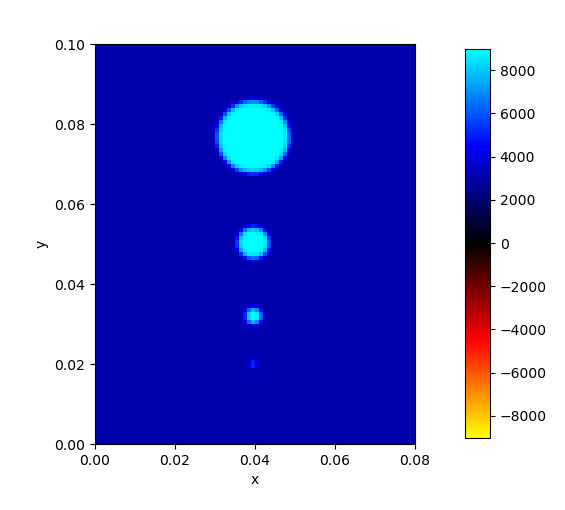

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [7]:
mu_matrix = 3e3 # Pa
mu_target = 9e3 # Pa
nu = 1 # Pa·s
omega = np.arange(50, 101, 10) # Hz
print(omega)

G_real = mu_matrix + im_pred.values * (mu_target - mu_matrix)
G_imag = 2 * np.pi * omega * nu
print(G_real.shape, G_imag.shape)

nax = np.newaxis
G = G_real[nax,nax,...] + 1j * G_imag[:,nax,nax,nax]
G = np.repeat(G, 10, axis=1) # repeat along z axis
print(G.shape)

# convert to xarray
G = xr.DataArray(
    G,
    dims=['frequency', 'z', 'x', 'y'],
    coords={'frequency': omega, 'z': np.arange(10) * 1e-3, 'x': np.arange(320) * dx, 'y': np.arange(400) * dx}
)

# downsample to data resolution
G_ds = G.coarsen(x=4, y=4).mean()

cmap = mre_pinn.visual.wave_color_map(reverse=True)

mre_pinn.visual.XArrayViewer(G_ds, dpi=25, cmap=cmap, vmin=-9000, vmax=9000)

(10, 320, 400)


<IPython.core.display.Javascript object>


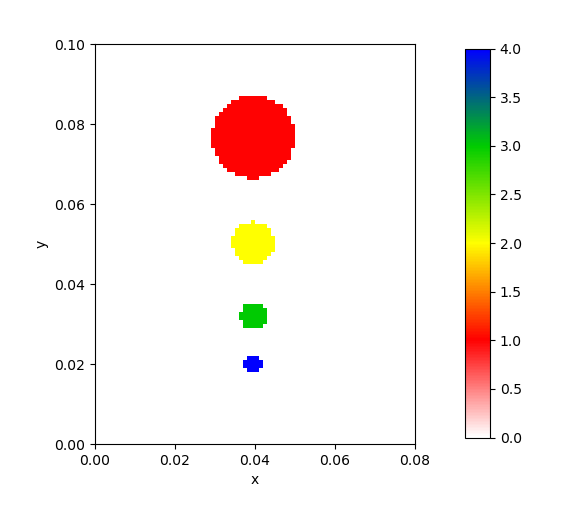

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [8]:
%autoreload

# create region segmentation mask

regions = 0
for c, r, t in zip(centers, radii, np.arange(1, 5)):
    regions = regions + (disk(x, c, r, power=2000) > 0.025) * t

regions = regions.reshape(im.shape).detach().cpu().numpy()
regions = regions[nax,...] # insert z axis
regions = np.repeat(regions, 10, axis=0) # repeat along z axis
print(regions.shape)
regions = xr.DataArray(
    regions,
    dims=['z', 'x', 'y'],
    coords={'x': np.arange(320) * dx, 'y': np.arange(400) * dx, 'z': np.arange(10) * dx}
)

# downsample to data resolution
regions_ds = regions.coarsen(x=4, y=4).max()

cmap = mre_pinn.visual.region_color_map()

mre_pinn.visual.XArrayViewer(
    regions_ds,
    dpi=25,
    cmap=cmap,
    vmin=0,
    vmax=4
)

In [9]:
np.save('../data/BIOQIC/fem_box_elastogram.npy', G_ds.values)
np.save('../data/BIOQIC/fem_box_regions.npy', regions_ds.values)

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
Loading ../data/BIOQIC/fem_box_elastogram.npy
     <class 'numpy.ndarray'> (6, 10, 80, 100) complex128
Loading ../data/BIOQIC/fem_box_regions.npy
     <class 'numpy.ndarray'> (10, 80, 100) int64
Multi frequency 3D
<xarray.Dataset>
Dimensions:         (frequency: 6, x: 80, y: 100, z: 10, component: 3)
Coordinates:
  * frequency       (frequency) float64 50.0 60.0 70.0 80.0 90.0 100.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
  * z               (z) float64 0.0 0.001 0.002 0.003 ... 0.007 0.008 0.009
  * component       (component) <U1 'z' 'y' 'x'
Data variables:
    u               (frequency, x, y, z, component) complex128 (7.43590828448...
    mu              (frequency, x,

<IPython.core.display.Javascript object>


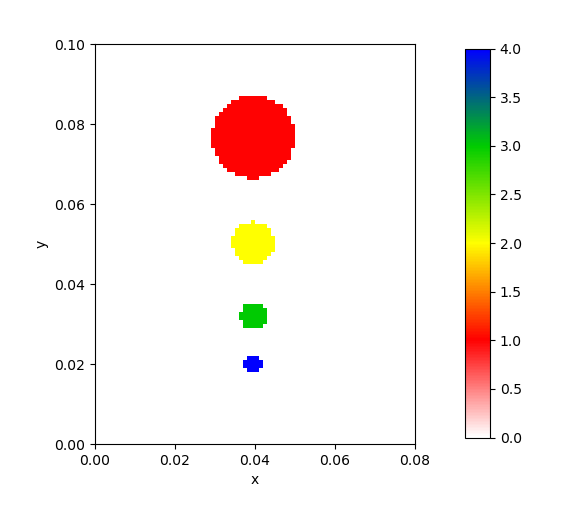

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


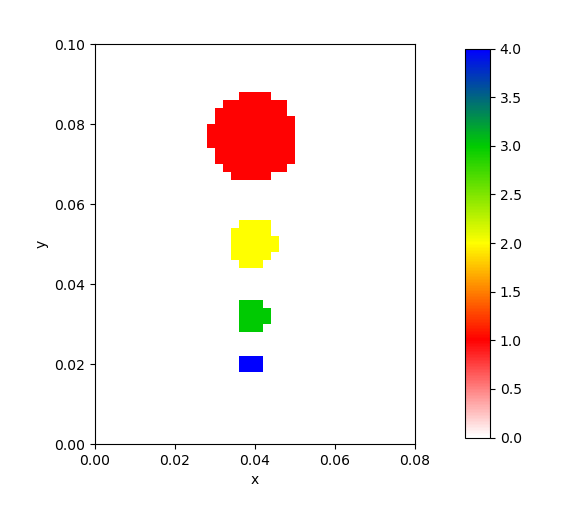

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [10]:
%autoreload

# now try loading the data set
data, test_data = mre_pinn.data.load_bioqic_dataset('../data/BIOQIC', 'fem_box')

cmap = mre_pinn.visual.region_color_map()

mre_pinn.visual.XArrayViewer(
    data.spatial_region,
    dpi=25,
    cmap=cmap,
    vmin=0,
    vmax=4
)
mre_pinn.visual.XArrayViewer(
    test_data.spatial_region,
    dpi=12.5,
    cmap=cmap,
    vmin=0,
    vmax=4
)

<IPython.core.display.Javascript object>


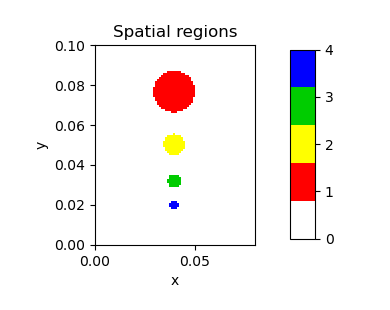

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


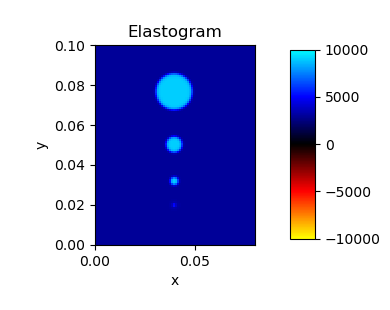

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


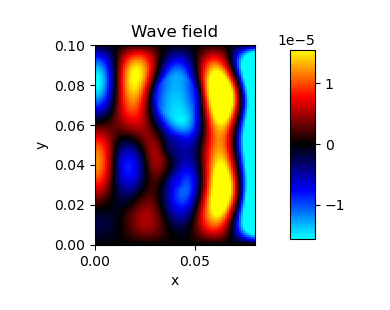

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [75]:
%autoreload

rmap = mre_pinn.visual.region_color_map(5)
wmap = mre_pinn.visual.wave_color_map()

viewer = mre_pinn.visual.XArrayViewer(data.spatial_region, dpi=50, cmap=rmap, space=0.35)
viewer.axes[0,0].set_title('Spatial regions')
viewer.fig.savefig('fem_box_regions.png', dpi=400, bbox_inches='tight')

viewer = mre_pinn.visual.XArrayViewer(data.mu, dpi=50, space=0.35, **mre_pinn.visual.get_color_kws(data.mu))
viewer.axes[0,0].set_title('Elastogram')
viewer.fig.savefig('fem_box_elastogram.png', dpi=400, bbox_inches='tight')

viewer = mre_pinn.visual.XArrayViewer(data.u, dpi=50, space=0.35, **mre_pinn.visual.get_color_kws(data.u))
viewer.axes[0,0].set_title('Wave field')
viewer.fig.savefig('fem_box_wave_field.png', dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


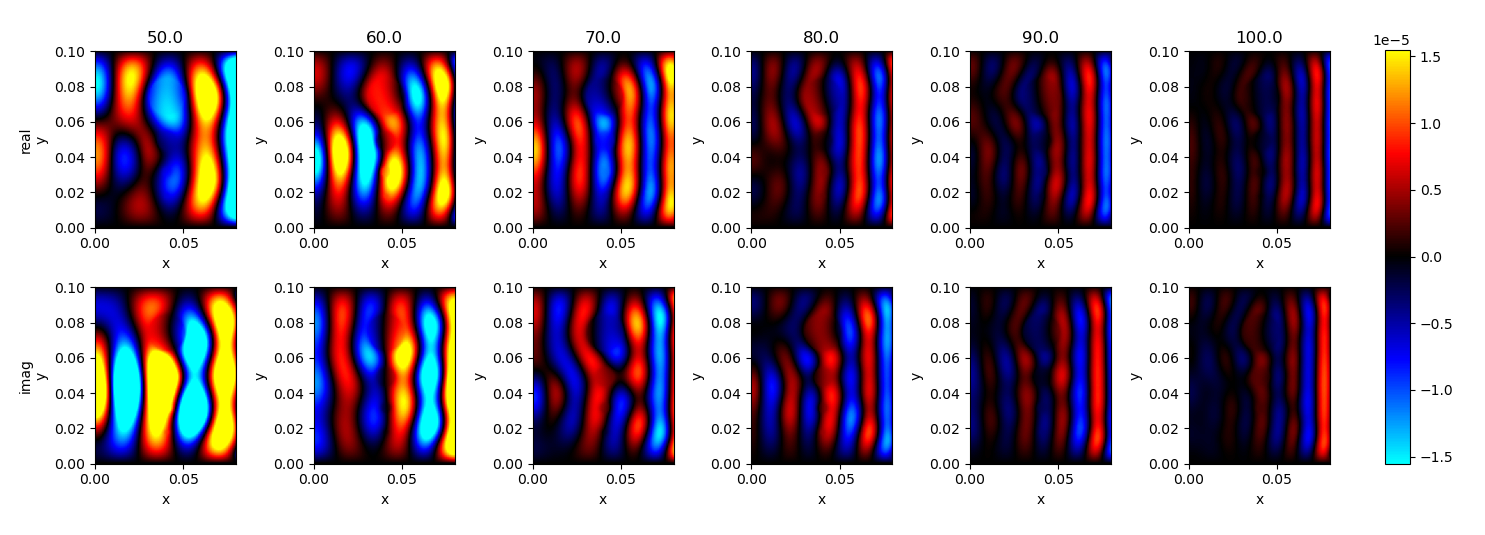

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [77]:
viewer = mre_pinn.visual.XArrayViewer(data.u, row='part', col='frequency', dpi=50, space=[0.25, 0.55], **mre_pinn.visual.get_color_kws(data.u))
viewer.fig.savefig('fem_box_wave_field_all.png', dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


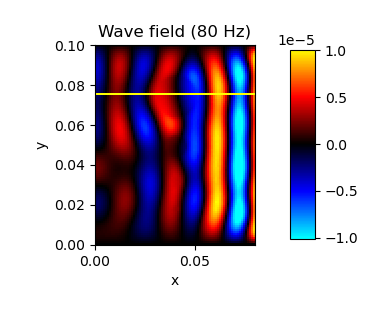

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


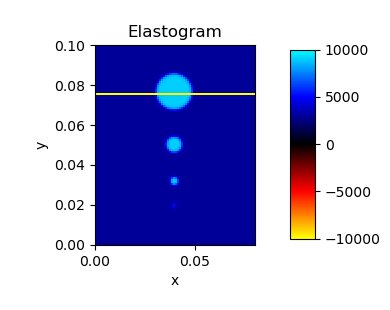

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [89]:
data_1d = data.sel(frequency=80)

u_line = data_1d.u * 0
u_line[:,75] = (1 + 1j) * 2

mu_line = data_1d.mu * 0
mu_line[:,75] = (1 + 1j) * -20e3

viewer = mre_pinn.visual.XArrayViewer(data_1d.u + u_line, dpi=50, space=0.35, **mre_pinn.visual.get_color_kws(data_1d.u))
viewer.axes[0,0].set_title('Wave field (80 Hz)')
viewer.fig.savefig('fem_box_wave_field_1D.png', dpi=400, bbox_inches='tight')

viewer = mre_pinn.visual.XArrayViewer(data_1d.mu + mu_line, dpi=50, space=0.35, **mre_pinn.visual.get_color_kws(data_1d.mu))
viewer.axes[0,0].set_title('Elastogram')
viewer.fig.savefig('fem_box_elastogram_1D.png', dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


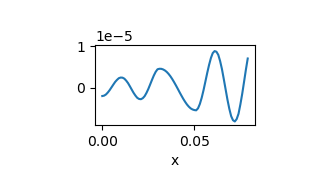

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


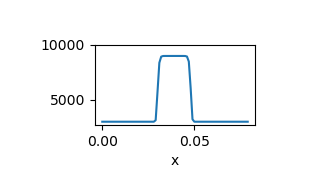

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [94]:
data_1d = data.sel(frequency=80).isel(y=75)

viewer = mre_pinn.visual.XArrayViewer(data_1d.u, y=None, dpi=50, space=0.35, **mre_pinn.visual.get_color_kws(data_1d.u))
viewer.fig.savefig('fem_box_wave_field_1D_line.png', dpi=400, bbox_inches='tight')

viewer = mre_pinn.visual.XArrayViewer(data_1d.mu, y=None, dpi=50, space=0.35, **mre_pinn.visual.get_color_kws(data_1d.mu))
viewer.fig.savefig('fem_box_elastogram_1D_line.png', dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


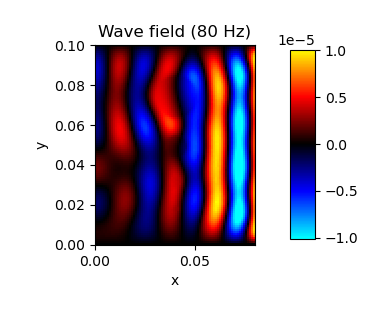

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


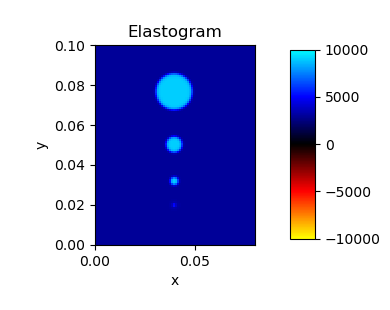

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [95]:
data_2d = data.sel(frequency=80)

viewer = mre_pinn.visual.XArrayViewer(data_2d.u, dpi=50, space=0.35, **mre_pinn.visual.get_color_kws(data_2d.u))
viewer.axes[0,0].set_title('Wave field (80 Hz)')
viewer.fig.savefig('fem_box_wave_field_2D.png', dpi=400, bbox_inches='tight')

viewer = mre_pinn.visual.XArrayViewer(data_2d.mu, dpi=50, space=0.35, **mre_pinn.visual.get_color_kws(data_2d.mu))
viewer.axes[0,0].set_title('Elastogram')
viewer.fig.savefig('fem_box_elastogram_2D.png', dpi=400, bbox_inches='tight')